# Generalizing Terrain w/ Fourier Transforms



In [1]:
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal

cm = 1/2.54  # centimeters in inches

from scipy import ndimage
from numpy.fft import fft2, fftshift, ifft2

In [2]:
#controlDEM = np.asarray(Image.open(r"./ConeDEM.tif"))
controlDEM = np.asarray(Image.open(r"../CraterLake.tif"))

cellsize = 3.33

In [3]:
from trf import shader, utils, surface

lv = utils.lightVector(315, 45)


# Control Image: 
We run the hillshade on the un-generalized DEM to see the hillshade and how its brightness values are distributed. 

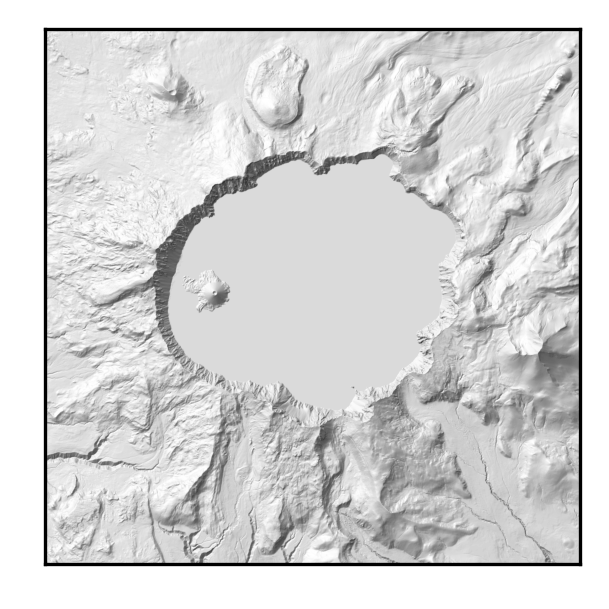

In [4]:
controlSNV = surface.normals_by_method(controlDEM, cellsize, "N82")
controlHS = shader.lambert(controlSNV, lv)

fig, axs = plt.subplots(1, 1, figsize=(6*cm, 6*cm))
fig.set_dpi(300)
axs.yaxis.set_visible(False)
axs.xaxis.set_visible(False)
axs.imshow(controlHS, cmap='gray', vmin=-1, vmax=1)

In [5]:
# Take 2D FFT of the height field, then 
# shift that so that low frequency is in the center of the plot, high frequency at edges
f = np.fft.fftshift(np.fft.fft2(controlDEM))

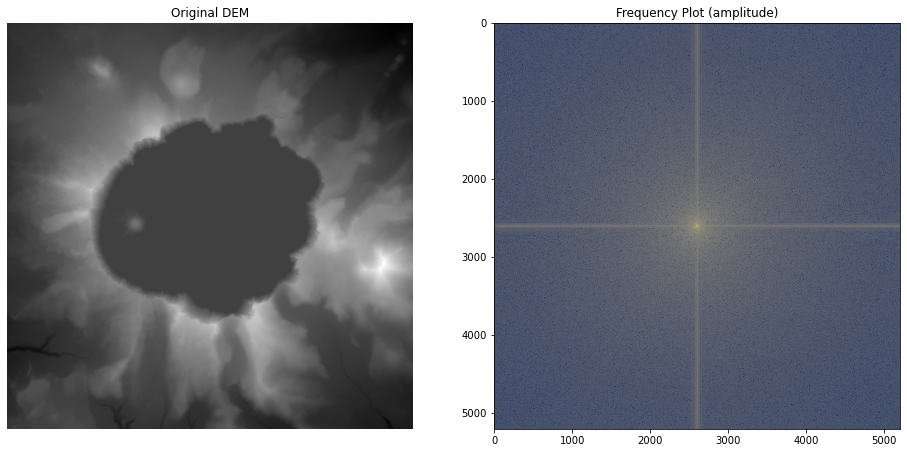

In [6]:
def amplitude(f):
    return np.sqrt(f.real**2 + f.imag**2)
    
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("Original DEM")
plt.axis('off')
plt.imshow(controlDEM, cmap='gray')
plt.subplot(1,2,2)
plt.title("Frequency Plot (amplitude)")
plt.axis('on')
plt.imshow(np.log(amplitude(f)), interpolation='none', cmap='cividis')
plt.show()

In [10]:
S = 128

input_ = np.fft.fft2(controlDEM)
result = ndimage.fourier_gaussian(input_, sigma=S)
fftDEM = np.fft.ifft2(result).real


fftSNV_x = np.zeros(controlSNV.shape)
for band in [0, 1, 2]:
    input_ = np.fft.fft2(controlSNV[band,:,:])
    result = ndimage.fourier_gaussian(input_, sigma=S)
    fftSNV_x[band,:,:]= np.fft.ifft2(result).real

mag = np.sqrt(fftSNV_x[0]**2 + fftSNV_x[1]**2 + fftSNV_x[2]**2)
fftSNV_x /= mag

In [11]:
fftSNV = surface.normals_by_method(fftDEM, cellsize, "N82")
fftHS = shader.lambert(fftSNV, lv)

fftHS_x = shader.lambert(fftSNV_x, lv)



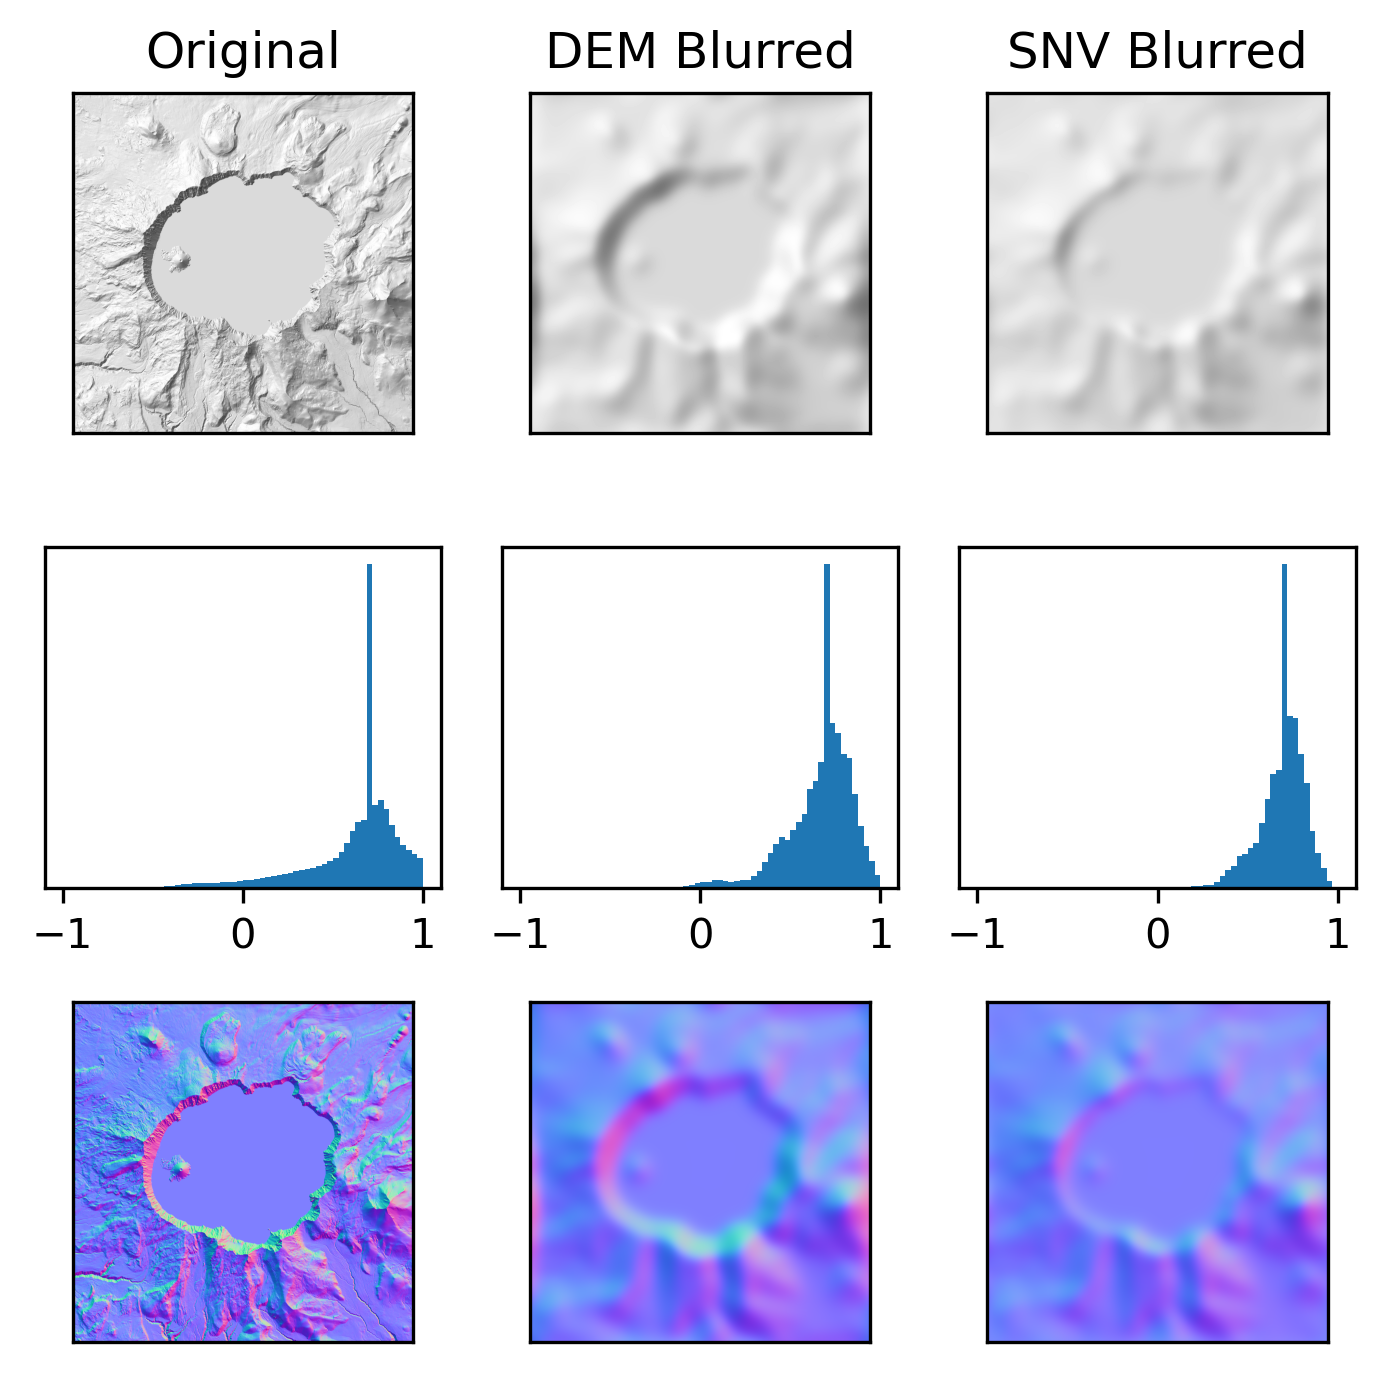

In [12]:
%matplotlib inline
fig, axs = plt.subplots(3,3, figsize=(12*cm, 12*cm))
fig.set_dpi(300)

for i in [0, 1, 2]:
    for j in [0, 1, 2]:
        axs[i,j].yaxis.set_visible(False)
        axs[i,j].xaxis.set_visible(False)


axs[0, 0].imshow(controlHS, cmap='gray', vmin=-1, vmax=1)
axs[0, 0].set_title("Original")
axs[1, 0].xaxis.set_visible(True)
axs[1, 0].hist(controlHS.ravel(), bins=64, range=[-1.0 ,1.0])
axs[2, 0].imshow((np.moveaxis(controlSNV, 0, 2)+1) / 2)


axs[0, 1].imshow(fftHS, cmap='gray', vmin=-1, vmax=1)
axs[0, 1].set_title("DEM Blurred")
axs[1, 1].xaxis.set_visible(True)
axs[1, 1].hist(fftHS.ravel(), bins=64, range=[-1.0 ,1.0])
axs[2, 1].imshow((np.moveaxis(fftSNV, 0, 2)+1) / 2)



axs[0, 2].imshow(fftHS_x, cmap='gray', vmin=-1, vmax=1)
axs[0, 2].set_title("SNV Blurred")
axs[1, 2].xaxis.set_visible(True)
axs[1, 2].hist(fftHS_x.ravel(), bins=64, range=[-1.0 ,1.0])
axs[2, 2].imshow((np.moveaxis(fftSNV_x, 0, 2) +1) / 2)

plt.tight_layout()

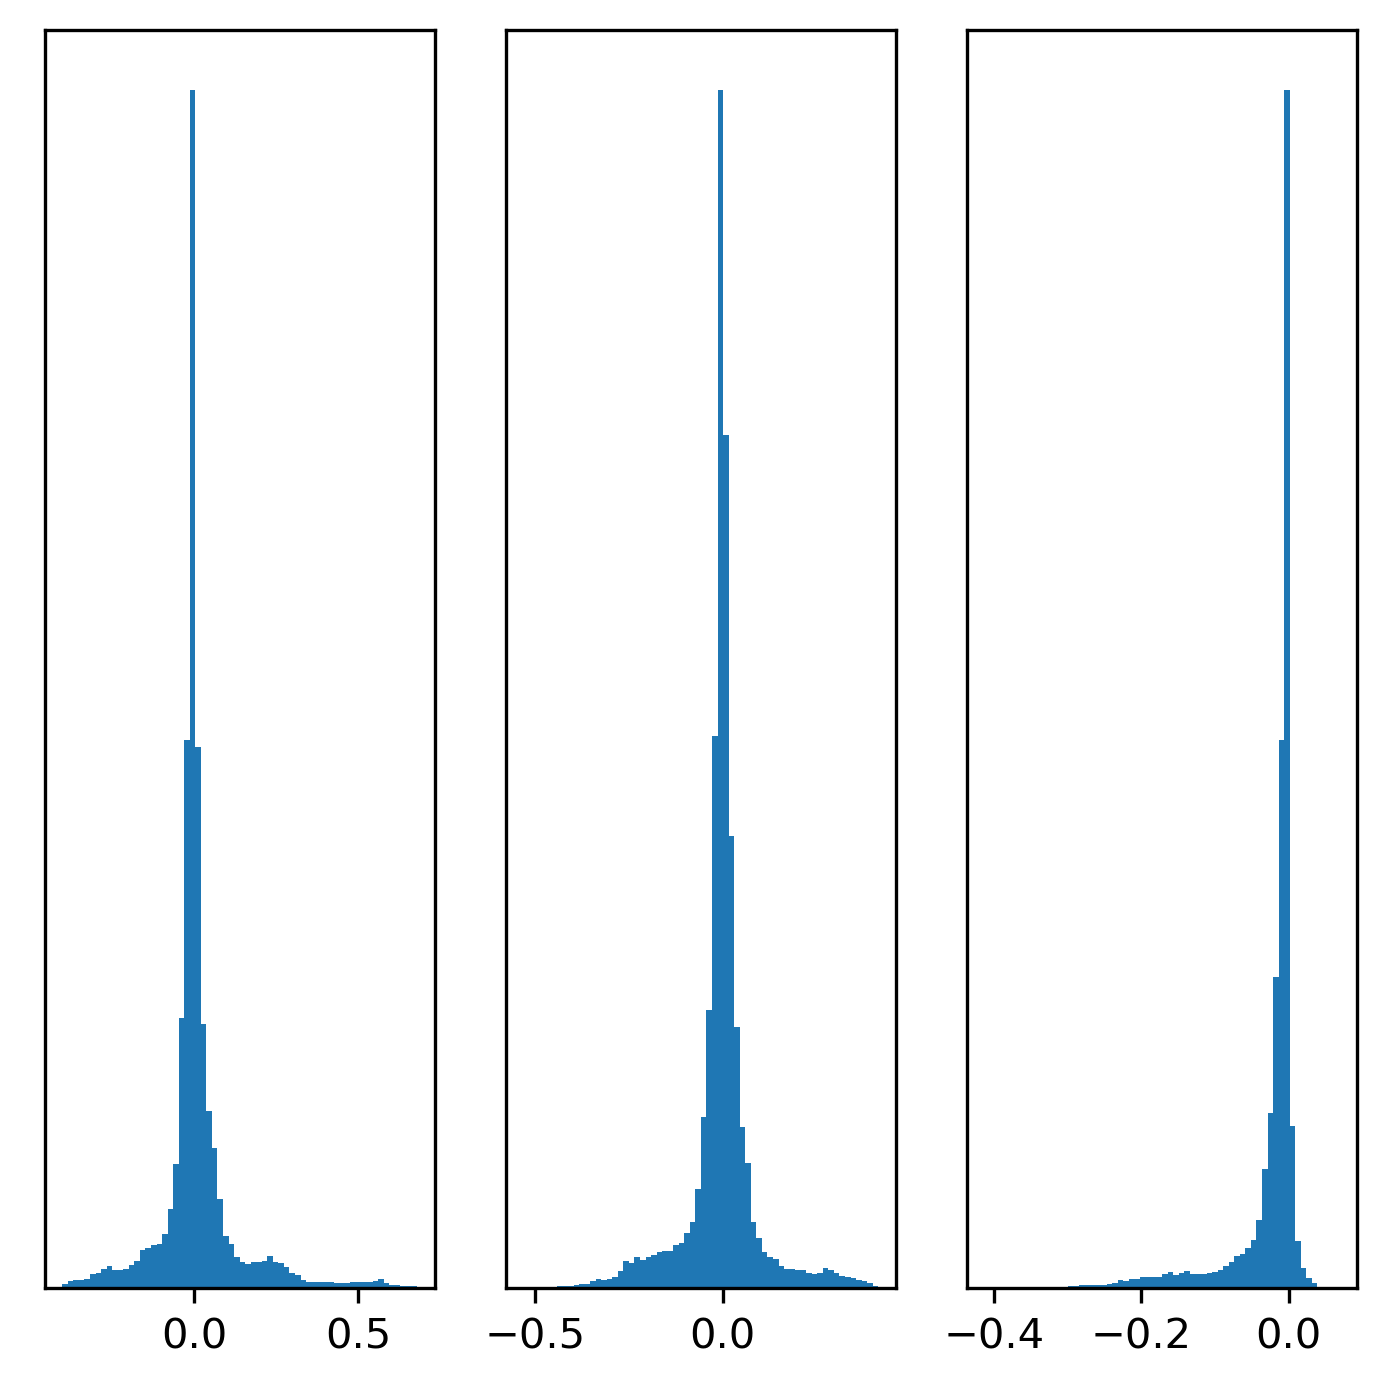

In [13]:
%matplotlib inline
fig, axs = plt.subplots(1,3, figsize=(12*cm, 12*cm))
fig.set_dpi(300)
for j in [0, 1, 2]:
    diff = fftSNV[j,:,:] - fftSNV_x[j,:,:]
    axs[j].yaxis.set_visible(False)
    #axs[j].xaxis.set_visible(False)
    axs[j].hist(diff.ravel(), bins=64)

plt.tight_layout()

In [15]:
%matplotlib widget
fig, axs = plt.subplots(1, 1, figsize=(6*cm, 6*cm))
fig.set_dpi(300)
axs.yaxis.set_visible(False)
axs.xaxis.set_visible(False)
axs.imshow(controlHS - fftHS_x, cmap='gray', vmin=-0.5, vmax=0.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …